In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


# Hands-on Exercise: Evaluating Credit Card Fraud Detection

In this exercise, we'll use the "Credit Card Fraud Detection" dataset from Kaggle to apply the evaluation metrics we've discussed. This dataset is highly imbalanced, making it a realistic scenario for anomaly detection.

## **1. Data Loading and Exploration**

First, we'll load the dataset and explore its characteristics.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")  # Replace "creditcard.csv" with the actual path

# Explore the class distribution
print("Class Distribution:\n", data['Class'].value_counts())

Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


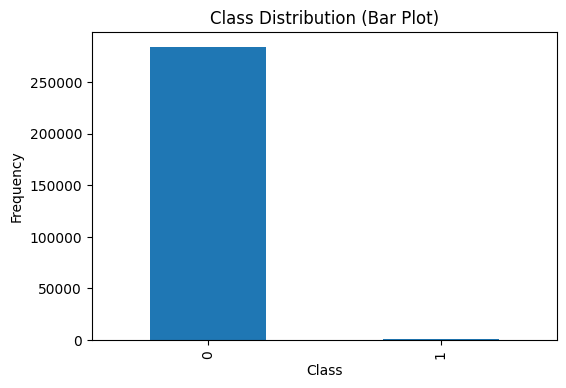

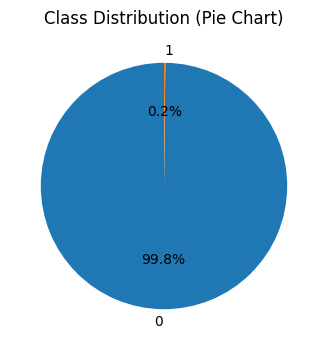

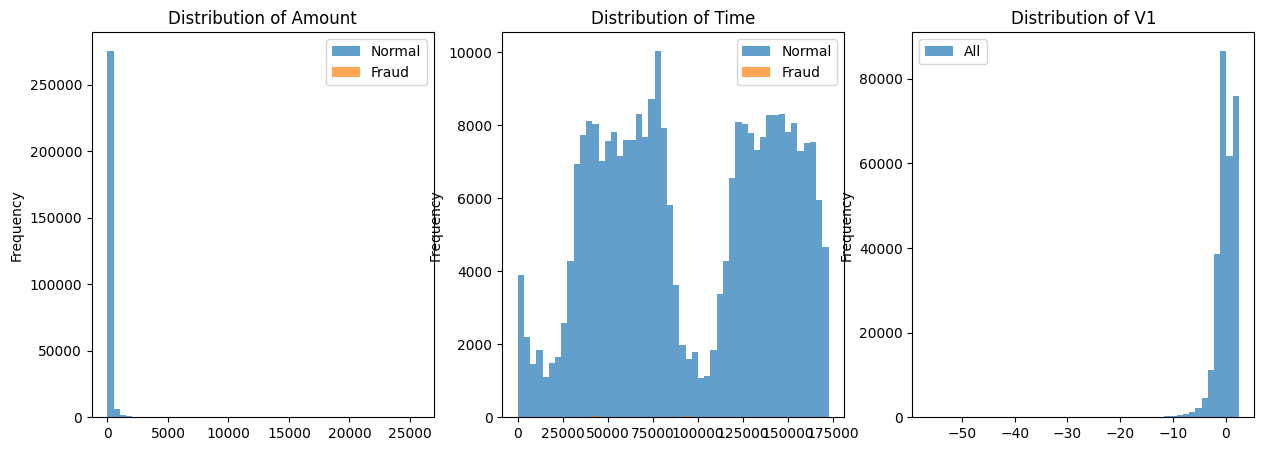

In [14]:
# Visualize the class distribution (Bar plot)
plt.figure(figsize=(6, 4))
data['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution (Bar Plot)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Visualize the class distribution (Pie chart)
plt.figure(figsize=(6, 4))
data['Class'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Pie Chart)')
plt.ylabel('')  # Hide the default label
plt.show()

# Feature Distribution Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
data[data['Class'] == 0]['Amount'].plot(kind='hist', bins=50, label='Normal', alpha=0.7)
data[data['Class'] == 1]['Amount'].plot(kind='hist', bins=50, label='Fraud', alpha=0.7)
plt.title('Distribution of Amount')
plt.legend()

plt.subplot(1, 3, 2)
data[data['Class'] == 0]['Time'].plot(kind='hist', bins=50, label='Normal', alpha=0.7)
data[data['Class'] == 1]['Time'].plot(kind='hist', bins=50, label='Fraud', alpha=0.7)
plt.title('Distribution of Time')
plt.legend()

plt.subplot(1, 3, 3)
data['V1'].plot(kind='hist', bins=50, label='All', alpha=0.7)
plt.title('Distribution of V1')
plt.legend()

plt.show()

In [15]:
# (Optional) Data Preprocessing: Scaling
# Scaling the 'Amount' feature can be beneficial for some algorithms
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop('Time', axis=1, inplace=True) # Time is not very useful here

* **Explanation:**

    * We load the dataset using pandas.
    * `data['Class'].value_counts()` shows the number of normal (0) and fraud (1) transactions, highlighting the imbalance.
    * We visualize the class distribution using both a bar plot and a pie chart for better understanding.
    * We plot histograms to visualize the distribution of 'Amount', 'Time' and 'V1' features for normal and fraud transactions. This helps in observing any potential differences.
    * Scaling the 'Amount' feature is often a good practice. We also drop the 'Time' feature as it might not be very informative for anomaly detection in this scenario.

**2. Anomaly Detection Model Training**

We'll use Isolation Forest for anomaly detection.

In [16]:
# Prepare the data for modeling
X = data.drop('Class', axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.001)  # Adjust contamination as needed
iso_forest.fit(X_train)

# Get anomaly scores and predictions
y_pred = iso_forest.predict(X_test)  # -1 for anomaly, 1 for normal
y_pred_binary = [1 if x == -1 else 0 for x in y_pred]  # Convert to 0 and 1
anomaly_scores = iso_forest.decision_function(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


* **Explanation:**

    * We separate the features (X) and the target variable (y, the 'Class' column).
    * We split the data into training and testing sets to evaluate the model's generalization ability.
    * We train the Isolation Forest model. The `contamination` parameter is an estimate of the proportion of outliers in the dataset. Adjust this parameter carefully.
    * `iso_forest.predict()` gives predictions (-1 for anomaly, 1 for normal). We convert these to 0 and 1 for consistency with the true labels.
    * `iso_forest.decision_function()` provides anomaly scores, which indicate the degree of "anomalousness" of each data point.

**3. Evaluation using Metrics**

Now, we'll calculate the evaluation metrics.

Confusion Matrix:
 [[56838    26]
 [   75    23]]
Precision: 0.4694
Recall: 0.2347
F1-score: 0.3129


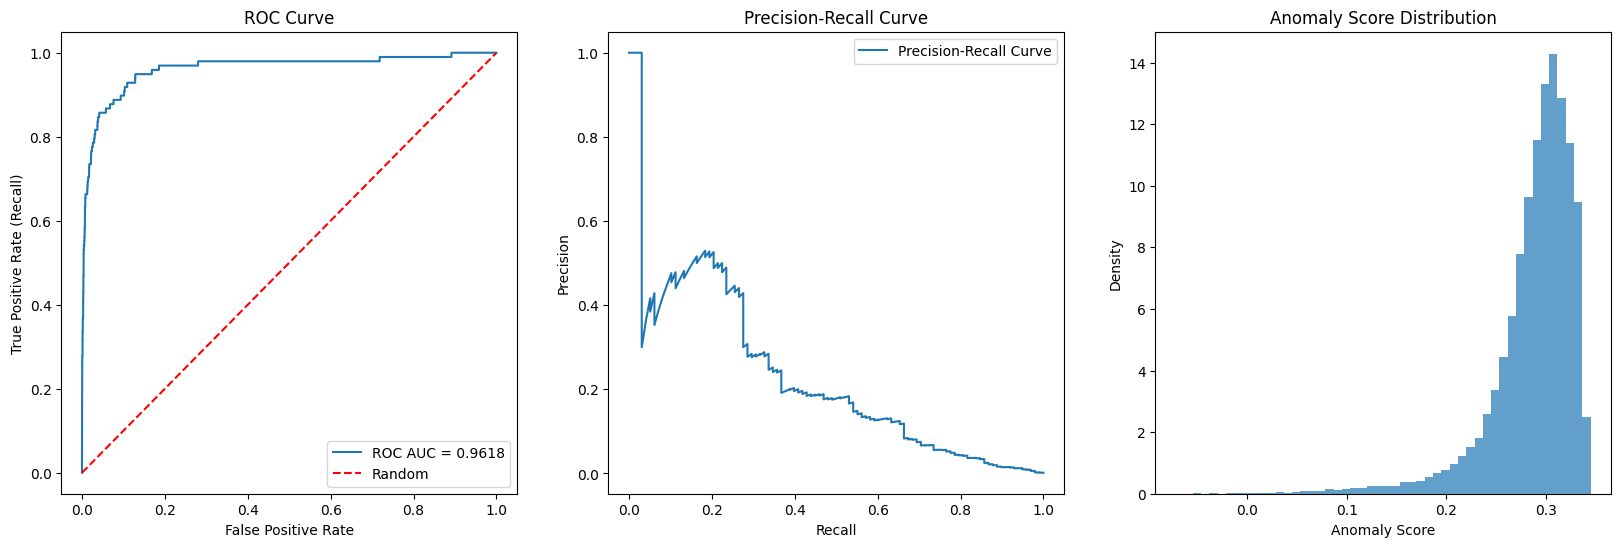

In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, F1-score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# ROC Curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, anomaly_scores * -1)  # Invert scores for ROC curve
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1,3, figsize=(20, 6))

axes[0].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate (Recall)')
axes[0].set_title('ROC Curve')
axes[0].legend()

# Precision-Recall Curve
precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_test, anomaly_scores * -1)

axes[1].plot(recall_pr, precision_pr, label='Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()

# Anomaly Score Distribution
axes[2].hist(anomaly_scores, bins=50, density=True, alpha=0.7)
axes[2].set_xlabel('Anomaly Score')
axes[2].set_ylabel('Density')
axes[2].set_title('Anomaly Score Distribution')

plt.show()

* **Explanation:**

    * We calculate the confusion matrix to understand the counts of TP, TN, FP, and FN.
    * We calculate precision, recall, and F1-score to evaluate the model's performance on anomaly detection.
    * For the ROC curve, we invert the `anomaly_scores` because `roc_curve` function expects scores to indicate the likelihood of the positive class.
    * We calculate the AUC to get a single measure of the model's ability to distinguish between normal and anomalous transactions.
    * The ROC curve visualization helps us understand the trade-off between TPR (recall) and FPR at different threshold settings.

**4. Interpretation and Discussion**

* **Interpretation:**

    * Analyze the confusion matrix to see how many fraud cases were correctly and incorrectly classified.
    * Discuss the precision and recall values. A high precision means that when the model flags a transaction as fraudulent, it's likely to be correct. A high recall means that the model can detect most of the fraudulent transactions.
    * Explain the F1-score as a balance between precision and recall.
    * Interpret the AUC score. An AUC closer to 1 indicates better performance.
    * Examine the ROC curve to understand the trade-off. For example, a point on the curve might show that to achieve a high recall, you might have to accept a higher FPR.

[Mentor Notes]
* **Discussion:**

    * In fraud detection, recall is often more critical than precision. It's usually better to flag a few more legitimate transactions (higher FPR, lower precision) than to miss a significant portion of fraudulent transactions (lower recall).
    * The choice of the threshold for classifying transactions as fraudulent depends on the business context and the costs associated with false positives and false negatives.
    * Discuss the challenges of applying anomaly detection in highly imbalanced datasets, where standard accuracy can be misleading.

This hands-on exercise provides a practical application of the evaluation metrics and highlights their importance in the context of credit card fraud detection.